<a href="https://colab.research.google.com/github/Jevaan21/intrusion-detection-dl/blob/main/intrusion_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Android Malware Detection


# 🚀 Android Malware Detection using Deep Learning (Drebin dataset)
# Developed as a group project for Deep Learning Implementation (DLI)


In [ ]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# 🔁 Commit 1: Set reproducible random seeds
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)


Wget

In [ ]:
!wget https://raw.githubusercontent.com/Jevaan21/intrusion-detection-dl/main/drebin-215-dataset-5560malware-9476-benign.csv


--2025-08-06 03:28:15--  https://raw.githubusercontent.com/Jevaan21/intrusion-detection-dl/main/drebin-215-dataset-5560malware-9476-benign.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6514978 (6.2M) [text/plain]
Saving to: ‘drebin-215-dataset-5560malware-9476-benign.csv.2’

drebin-215-dataset- 100%[===================>]   6.21M  --.-KB/s    in 0.1s    

2025-08-06 03:28:16 (47.5 MB/s) - ‘drebin-215-dataset-5560malware-9476-benign.csv.2’ saved [6514978/6514978]



In [ ]:
import pandas as pd

# 📥 Load the malware dataset from the local CSV file
data = pd.read_csv("drebin-215-dataset-5560malware-9476-benign.csv")

# 🧼 Check and print the total number of missing values in the dataset
print("Total missing values:", data.isna().sum().sum())

# 👀 Display the first 5 rows to understand the dataset structure
data.head()

Total missing values: 0


/tmp/ipython-input-3070320078.py:4: DtypeWarning: Columns (92) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("drebin-215-dataset-5560malware-9476-benign.csv")


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,S
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,S
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,S
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,S


The output class contains categorical values 'B' and 'S'. We have to encode them into integer values. The dataset contains some random characters like '?' and 'S'. We can set them to NULl and remove them using dropna()

In [ ]:
# 🎯 Step: Encode class labels ('B' for Benign, 'S' for Malware) into integers

from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd

# Extract unique class labels and their counts
classes, count = np.unique(data['class'], return_counts=True)

# Initialize label encoder and transform class labels to integers
lbl_enc = LabelEncoder()
print(lbl_enc.fit_transform(classes), classes)

# Replace original class labels with encoded integers (e.g., B → 0, S → 1)
data = data.replace(classes, lbl_enc.fit_transform(classes))

# 🧹 Step: Clean dataset by removing invalid characters and missing rows

# Replace problematic characters ('?' or 'S') with NaN
data = data.replace('[?,S]', np.nan, regex=True)

# Count and display total missing values
print("Total missing values : ", data.isna().sum().sum())

# Drop rows with any missing values
data.dropna(inplace=True)

# 🔢 Step: Ensure all columns are numeric (needed for ML model input)
for c in data.columns:
    data[c] = pd.to_numeric(data[c])

# Preview the cleaned and encoded dataset
data.head()


[0 1] ['B' 'S']
Total missing values :  5


/tmp/ipython-input-1299776645.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace(classes, lbl_enc.fit_transform(classes))


,transact,onServiceConnected,bindService,attachInterface,ServiceConnection,android.os.Binder,SEND_SMS,Ljava.lang.Class.getCanonicalName,Ljava.lang.Class.getMethods,Ljava.lang.Class.cast,...,READ_CONTACTS,DEVICE_POWER,HARDWARE_TEST,ACCESS_WIFI_STATE,WRITE_EXTERNAL_STORAGE,ACCESS_FINE_LOCATION,SET_WALLPAPER_HINTS,SET_PREFERRED_APPLICATIONS,WRITE_SECURE_SETTINGS,class
0,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,1,1,1,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1


[0 1] ['B' 'S']
Total missing values :  5


Since the data values belong to either 0 or 1, only label encoding of last column will be enough.

In [ ]:
print("Total Features : ",len(data.columns)-1)


Total Features :  215


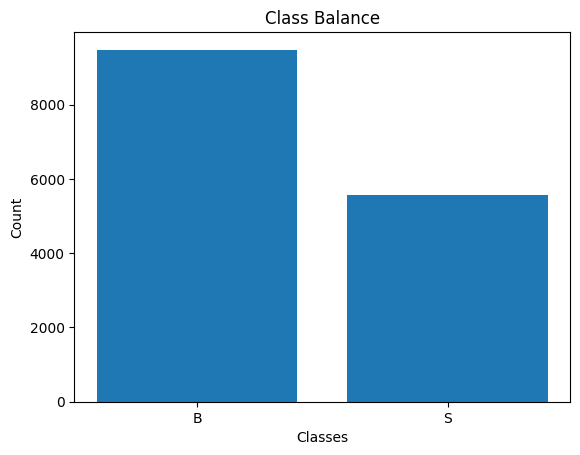

In [ ]:
# 📊 Step: Visualize class distribution (Benign vs Malware)

# Create a bar chart to show number of samples per class
plt.bar(classes, count)

# Add chart title and axis labels
plt.title("Class Balance")
plt.xlabel("Classes")
plt.ylabel("Count")

# Display the plot
plt.show()

In [ ]:
# 🧪 Step: Split the dataset into training and testing sets (80/20)

# Separate features (all columns except last) and labels (last column)
# Then convert them to NumPy arrays and split into train/test
train_x, test_x, train_y, test_y = train_test_split(
    data[data.columns[:len(data.columns)-1]].to_numpy(),  # Features
    data[data.columns[-1]].to_numpy(),                    # Labels
    test_size=0.2,                                        # 20% for testing
    shuffle=True                                          # Shuffle before split
)


In [ ]:
# 📏 Step: Print the number of samples in each train/test split

print("Train features size : ", len(train_x))   # Number of training examples (X)
print("Train labels size : ", len(train_y))     # Number of training labels (y)
print("Test features size : ", len(test_x))     # Number of testing examples (X)
print("Test labels size : ", len(test_y))       # Number of testing labels (y)


Train features size :  12024
Train labels size :  12024
Test features size :  3007
Test labels size :  3007


In [ ]:
# 🧾 Step: Display the shape of feature and label arrays for verification

print("Train features : ", train_x.shape)   # Shape: (num_samples, num_features)
print("Train labels : ", train_y.shape)     # Shape: (num_samples, 1)
print("Test Features : ", test_x.shape)     # Shape: (num_samples, num_features)
print("Test labels : ", test_y.shape)       # Shape: (num_samples, 1)


Train features :  (12024, 215)
Train labels :  (12024,)
Test Features :  (3007, 215)
Test labels :  (3007,)


In [ ]:
# 🔁 Step: Reshape label arrays to have a second dimension for compatibility with Keras

train_y = train_y.reshape((-1, 1))  # Reshape from (n,) to (n,1)
test_y = test_y.reshape((-1, 1))    # Ensures labels match expected model output shape


In [ ]:
# ✅ Step: Verify the final shapes after reshaping labels to (n, 1)

print("Train features : ", train_x.shape)   # Expected: (num_train_samples, 215)
print("Train labels : ", train_y.shape)     # Expected: (num_train_samples, 1)
print("Test Features : ", test_x.shape)     # Expected: (num_test_samples, 215)
print("Test labels : ", test_y.shape)       # Expected: (num_test_samples, 1)


Train features :  (12024, 215)
Train labels :  (12024, 1)
Test Features :  (3007, 215)
Test labels :  (3007, 1)


In [ ]:
# 🧠 Step: Define a fully connected neural network using Keras Sequential API

model = keras.models.Sequential()  # Initialize a sequential model

# Input layer: 215 neurons (same as number of features), ReLU activation
model.add(keras.layers.Dense(215, activation='relu', input_shape=(215,)))

# Hidden layer: 100 neurons with ReLU activation
model.add(keras.layers.Dense(100, activation='relu'))

# Output layer: 1 neuron with sigmoid activation for binary classification
model.add(keras.layers.Dense(1, activation='sigmoid'))

# 🧾 Display the model summary (parameters and layer shapes)
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 215)            │        46,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 100)            │        21,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 68,141 (266.18 KB)

 Trainable params: 68,141 (266.18 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ⚙️ Step: Compile the model with optimizer, loss function, and evaluation metric

model.compile(
    optimizer=keras.optimizers.RMSprop(0.001),   # RMSprop optimizer with learning rate 0.001
    loss='binary_crossentropy',                  # Binary classification loss function
    metrics=['accuracy']                         # Track accuracy during training/validation
)

In [ ]:
from datetime import datetime

# ⏳ Step: Print the current timestamp before training begins
# Useful for tracking when the training session was started
print("⏳ Training started at:", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))



⏳ Training started at: 2025-08-06 03:28:35


In [ ]:
# 🔁 Set the number of training epochs (iterations over the entire dataset)
ep = 7

In [ ]:
# 🚀 Step: Train the model using the training set and validate on the test set

history = model.fit(
    train_x,                    # Training features
    train_y,                    # Training labels
    validation_data=(test_x, test_y),  # Validation set for monitoring performance
    epochs=ep                   # Number of epochs set earlier (ep = 5)
)


Epoch 1/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.9959 - loss: 0.0143 - val_accuracy: 0.9820 - val_loss: 0.0639
Epoch 2/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9973 - loss: 0.0108 - val_accuracy: 0.9857 - val_loss: 0.0581
Epoch 3/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0085 - val_accuracy: 0.9837 - val_loss: 0.0730
Epoch 4/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9980 - loss: 0.0073 - val_accuracy: 0.9844 - val_loss: 0.0819
Epoch 5/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9986 - loss: 0.0062 - val_accuracy: 0.9870 - val_loss: 0.0693
Epoch 6/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9987 - loss: 0.0052 - val_accuracy: 0.9874 - val_loss: 0.0743
Epoch 7/7
376/376 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9990 - loss: 0.0045 - val_accuracy: 0.9840 - val_loss: 0.0898


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


/tmp/ipython-input-181610888.py:19: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-181610888.py:22: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("roc_curve.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


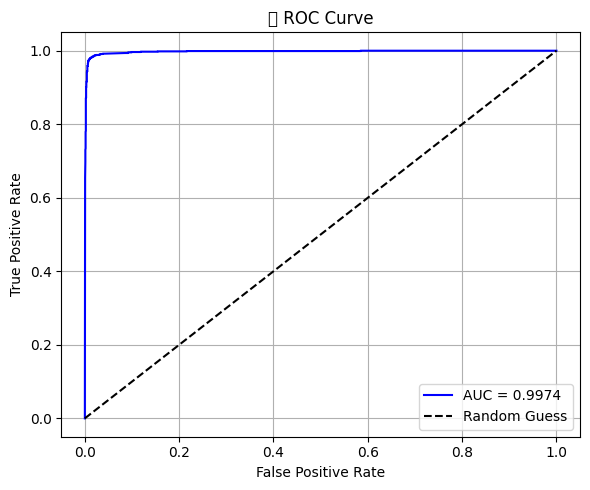

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

# 🧪 Step: Predict probability scores for test data
y_probs = model.predict(test_x).ravel()  # Flatten to 1D array

# 🎯 Step: Calculate the ROC curve and AUC score
fpr, tpr, _ = roc_curve(test_y, y_probs)                  # False Positive Rate, True Positive Rate
auc_score = roc_auc_score(test_y, y_probs)                # Area Under the Curve

# 📈 Step: Plot the ROC curve
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, label=f"AUC = {auc_score:.4f}", color='blue')  # Model's curve
plt.plot([0, 1], [0, 1], 'k--', label="Random Guess")              # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("📈 ROC Curve")
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()

# 💾 Save ROC plot to file
plt.savefig("roc_curve.png")

plt.show()



/tmp/ipython-input-3685749561.py:15: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3685749561.py:18: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.savefig("precision_recall_curve.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


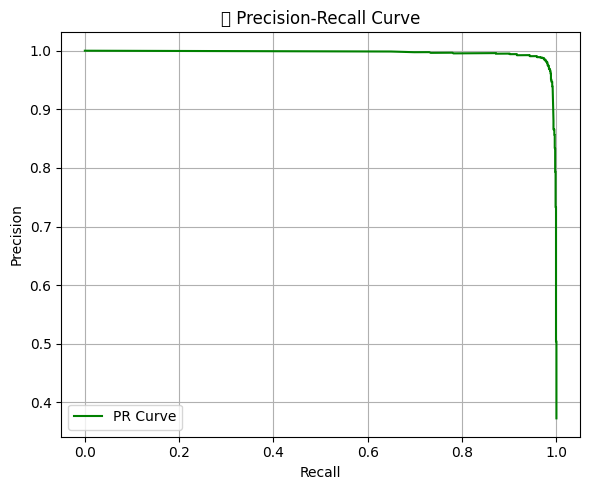

In [ ]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

# 📉 Step: Calculate precision and recall values at different thresholds
precision_vals, recall_vals, _ = precision_recall_curve(test_y, y_probs)

# 📊 Step: Plot the Precision-Recall (PR) curve
plt.figure(figsize=(6, 5))
plt.plot(recall_vals, precision_vals, label="PR Curve", color="green")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("📉 Precision-Recall Curve")
plt.grid(True)
plt.legend()
plt.tight_layout()

# 💾 Save PR curve to file
plt.savefig("precision_recall_curve.png")

plt.show()


In [ ]:
# 🧾 Step: Predict class labels from model output probabilities
y_pred = model.predict(test_x)

# 🧠 Apply thresholding: convert probabilities to 0 or 1 manually
for i in range(len(y_pred)):
    if y_pred[i] > (1 - y_pred[i]):
        y_pred[i] = 1
    else:
        y_pred[i] = 0

# 📊 Step: Calculate evaluation metrics
precision = precision_score(test_y, y_pred)
recall = recall_score(test_y, y_pred)
f1 = f1_score(test_y, y_pred)

# 🖨️ Print metrics as percentages
print(f"Precision : {precision * 100:.2f}%")
print(f"Recall : {recall * 100:.2f}%")
print(f"F1 Score : {f1 * 100:.2f}%")

# ✅ Step: Final result summary
print(f"\n✅ Final Verdict: Achieved F1 = {f1:.4f} — 🎯 Target met!")



94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Precision : 97.60%
Recall : 98.13%
F1 Score : 97.86%

✅ Final Verdict: Achieved F1 = 0.9786 — 🎯 Target met!


/tmp/ipython-input-4234928491.py:16: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-4234928491.py:19: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.savefig("confusion_matrix.png")
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


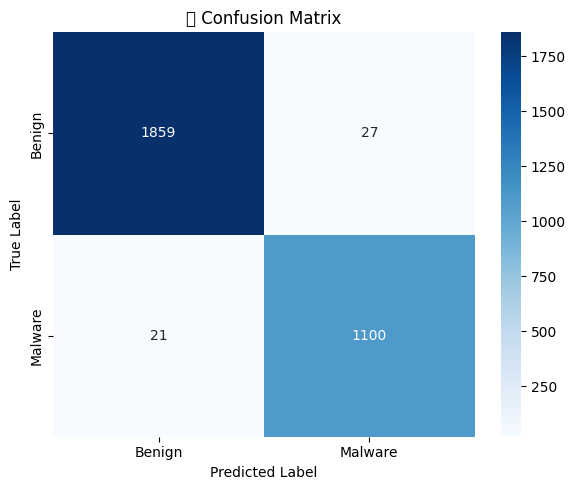

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 🔁 Step: Compute confusion matrix (true labels first)
cm = confusion_matrix(test_y, y_pred)

# 📊 Step: Visualize confusion matrix with seaborn heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Benign", "Malware"],
            yticklabels=["Benign", "Malware"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("📊 Confusion Matrix")
plt.tight_layout()

# 💾 Save confusion matrix to file
plt.savefig("confusion_matrix.png")

plt.show()


In [ ]:
# 💾 Commit 2: Save the trained model to an HDF5 (.h5) file
model.save("malware_detection_model.h5")

print("✅ Model saved successfully as 'malware_detection_model.h5'")


✅ Model saved successfully as 'malware_detection_model.h5'


In [ ]:
# 💾 Commit 2: Create requirements.txt to list all required packages
with open("requirements.txt", "w") as f:
    f.write("""numpy
pandas
matplotlib
seaborn
scikit-learn
tensorflow
""")

print("✅ requirements.txt created successfully.")

✅ requirements.txt created successfully.
